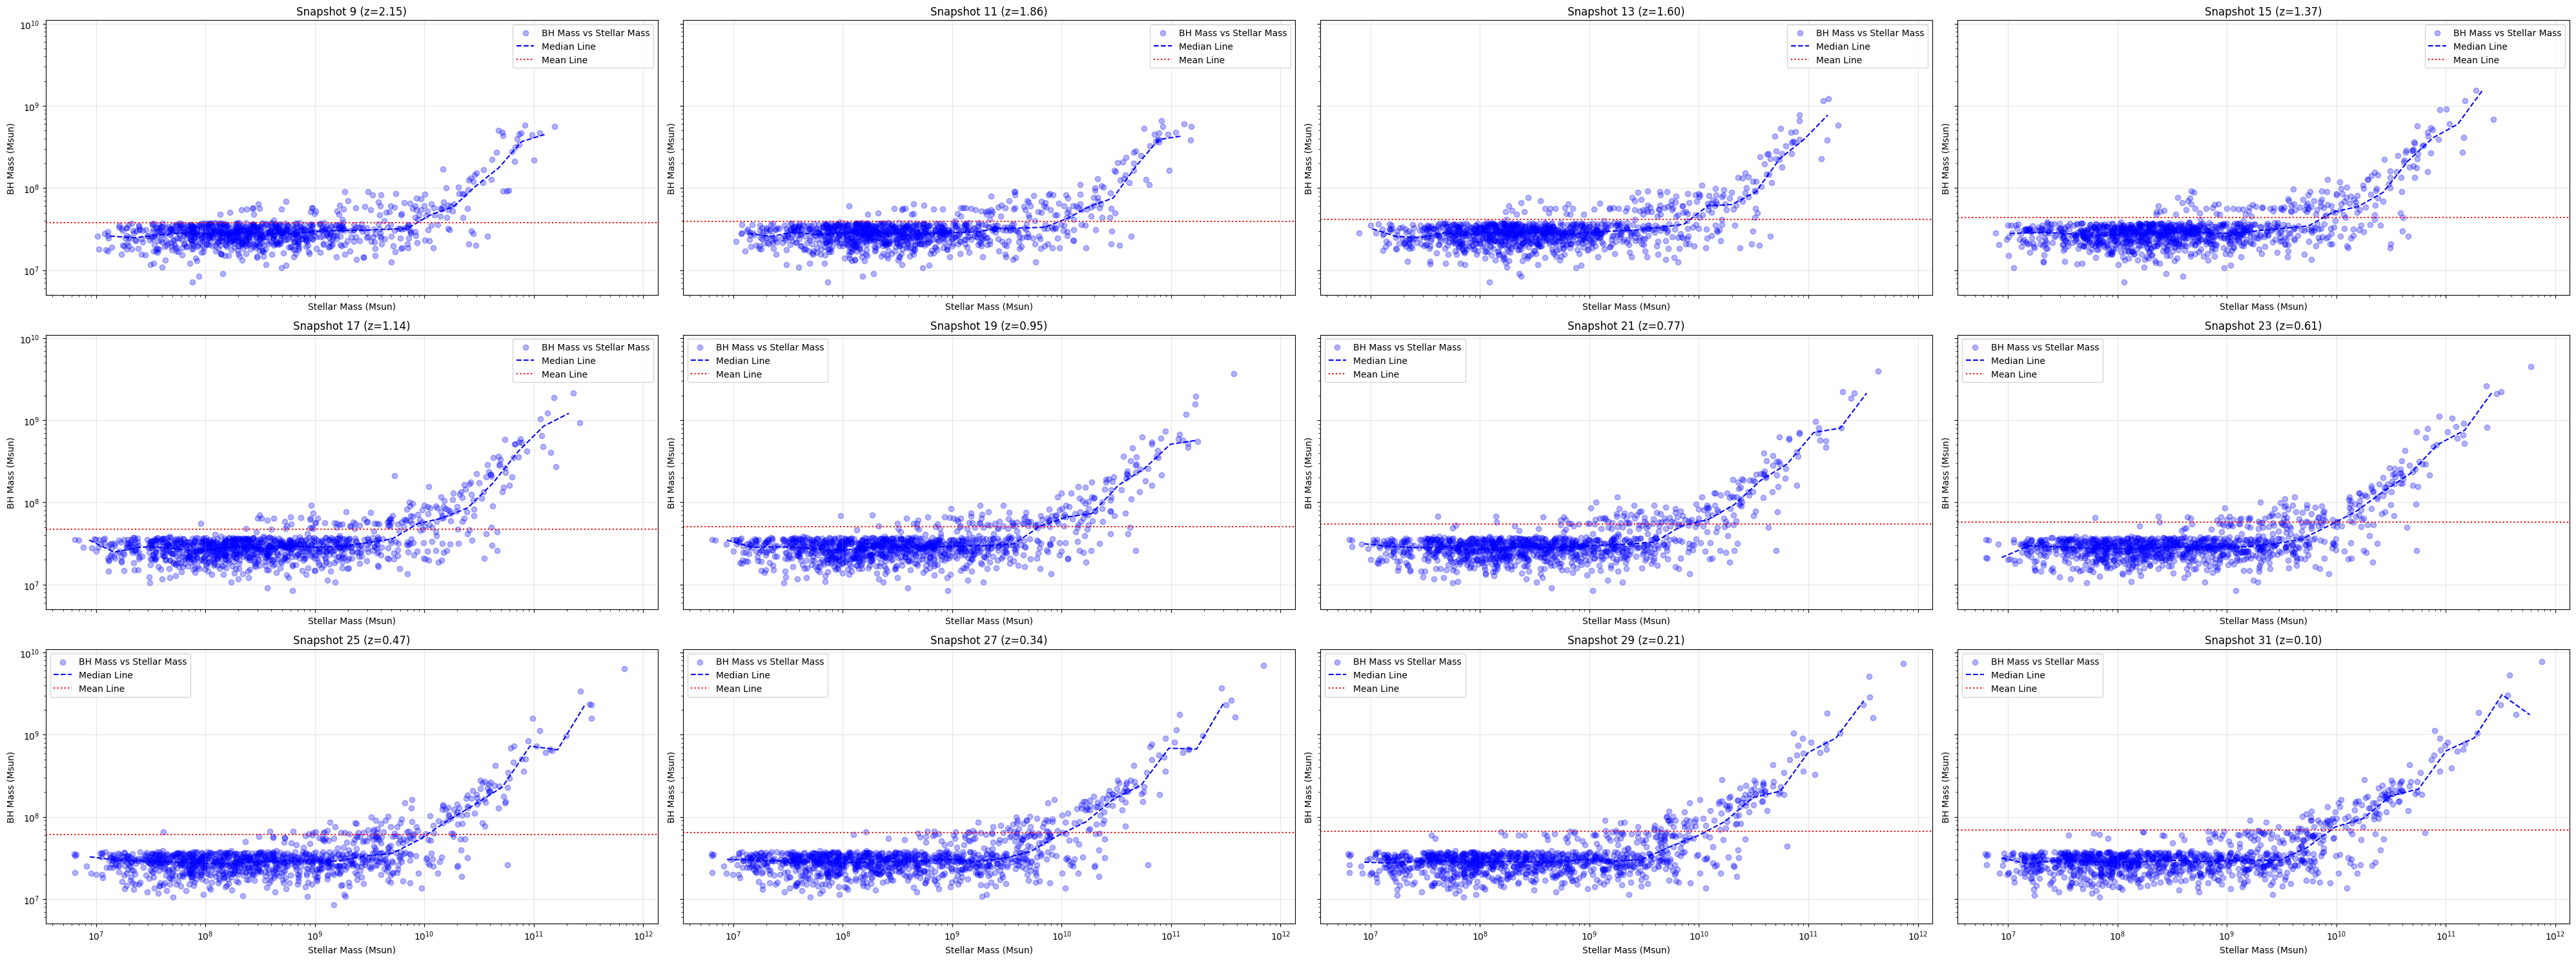

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
h = 0.6711

def bin_data_with_mask(x, y, num_bins=20):
    bins = np.geomspace(np.min(x), np.max(x), num_bins + 1)
    bin_indices = np.digitize(x, bins) - 1
    bin_averages = [np.median(y[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(num_bins)]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, np.array(bin_averages), x, y

def snapshot_graph_bh_vs_galactic_stellar_mass(): 
    num_snapshots = 12
    num_cols = 4
    num_rows = 3  
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 5 * num_rows), sharex=True, sharey=True)  
    
    plot_count = 0
    skipped_groups = 0
    total_groups = 0
    
    for i in range(9, 33, 2):
        bh_masses = []
        stellar_masses = []
        
        result = f"{i:03d}"
        file_path = f"./data/Output-fidTNG/snap_{result}.hdf5"
        f_catalog = f"./data/Output-fidTNG/fof_subhalo_tab_{result}.hdf5"

        try:
            with h5py.File(file_path, "r") as data, h5py.File(f_catalog, 'r') as f:
                redshift = data["Header"].attrs["Redshift"]
                
                subhalo_group_nr = f['Subhalo/SubhaloGroupNr'][:]
                subhalo_stellar_mass = f["Subhalo/SubhaloMassType"][:, 4] * 1e10 / h # Stellar mass (Msun)
                subhalo_bh_masses = f["Subhalo/SubhaloMassType"][:, 5] * 1e10  / h # BH mass
                
                for subgroup_idx in range(len(subhalo_group_nr)):
                    bh_masses.append(subhalo_bh_masses[subgroup_idx])
                    stellar_masses.append(subhalo_stellar_mass[subgroup_idx])
                
        except FileNotFoundError:
            print(f"Snapshot file {file_path} or catalog {f_catalog} not found. Skipping...")
            continue
        
        # Convert to numpy arrays
        bh_masses = np.array(bh_masses)
        stellar_masses = np.array(stellar_masses)

        # Remove zeros
        valid_indices = np.where((bh_masses != 0) & (stellar_masses != 0))[0]
        bh_masses = bh_masses[valid_indices]
        stellar_masses = stellar_masses[valid_indices]

        # Bin data
        binned_x, bin_averages, rawX, rawY = bin_data_with_mask(stellar_masses, bh_masses)
        
        # Compute mean for the entire dataset
        mean_bh_mass = np.mean(bh_masses)

        # Plotting
        ax = axs[plot_count // num_cols, plot_count % num_cols]
        ax.scatter(rawX, rawY, color="blue", alpha=0.3, label="BH Mass vs Stellar Mass")
        ax.plot(binned_x, bin_averages, color="blue", linestyle="--", label="Median Line")


        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Stellar Mass (Msun)")
        ax.set_ylabel("BH Mass (Msun)")
        ax.set_title(f"Snapshot {i} (z={redshift:.2f})")
        ax.grid(alpha=0.3)
        ax.legend()

        plot_count += 1

    plt.tight_layout()
    plt.show()

snapshot_graph_bh_vs_galactic_stellar_mass()